In [4]:
# %pip install qiskit
# %pip install qiskit_aer
# %pip install qiskit_ibm_runtime
# %pip install matplotlib
# %pip install numpy


In [1]:
import math, csv
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit.transpiler import generate_preset_pass_manager
from qiskit.quantum_info import SparsePauliOp
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_aer.noise import NoiseModel, thermal_relaxation_error


In [2]:
SHOTS_SIM = 2000
SHOTS_HW  = 4000

TAUS_NS = np.array([0, 200, 400, 800, 1600, 3200, 6400, 12800])

T1_NS = 80_000   # 80 μs
T2_NS = 40_000   # 40 μs

In [3]:
def ramsey_circuit(tau_ns: int) -> QuantumCircuit:
    q = QuantumRegister(1, "q")
    cr = ClassicalRegister(1, "cr")
    qc = QuantumCircuit(q, cr)
    qc.rx(np.pi/2, q[0])
    qc.delay(int(tau_ns), q[0], unit="ns")
    qc.rx(np.pi/2, q[0])
    qc.measure(q[0], cr[0])
    return qc

def hahn_echo_circuit(tau_ns: int) -> QuantumCircuit:
    q = QuantumRegister(1, "q")
    cr = ClassicalRegister(1, "cr")
    qc = QuantumCircuit(q, cr)
    qc.rx(np.pi/2, q[0])
    qc.delay(int(tau_ns), q[0], unit="ns")
    qc.x(q[0])
    qc.delay(int(tau_ns), q[0], unit="ns")
    qc.rx(-np.pi/2, q[0])
    qc.measure(q[0], cr[0])
    return qc

In [4]:
def fit_exp_decay(t, y, total_idle_factor=1.0):
    """
    Fit y ≈ A*exp(-(total_idle_factor * t)/T2) + C
    """
    C = float(y[-1])
    y_shift = np.clip(y - C, 1e-8, None)
    slope, intercept = np.polyfit(total_idle_factor*t, np.log(y_shift), 1)
    T2 = -1.0/slope if slope < 0 else np.inf
    A = math.exp(intercept)
    return A, C, T2

In [5]:
def run_simulation(taus, shots):
    noise = NoiseModel()
    try:
        delay_err = thermal_relaxation_error(T1_NS, T2_NS, duration=1, time_unit="ns")
    except TypeError:
        delay_err = thermal_relaxation_error(T1_NS, T2_NS, 1)
    noise.add_all_qubit_quantum_error(delay_err, "delay")
    backend = AerSimulator(noise_model=noise)

    ramsey, echo = [], []
    for tau in taus:
        for circ_func, arr in [(ramsey_circuit, ramsey), (hahn_echo_circuit, echo)]:
            qc = circ_func(int(tau))
            tqc = transpile(qc, backend)  # no scheduling on Aer
            res = backend.run(tqc, shots=shots).result().get_counts()
            arr.append(res.get("0", 0) / shots)
    return {"taus": np.array(taus), "ramsey": np.array(ramsey), "echo": np.array(echo)}

# run it
sim = run_simulation(TAUS_NS, SHOTS_SIM)
print(sim.keys())

dict_keys(['taus', 'ramsey', 'echo'])


In [6]:
token="wT9ezlCVkzgngguVBoFUEo0n2U9ZPq0xJPkOu0vR8C4M"

In [7]:
def _extract_counts(entry):
    if hasattr(entry, "data") and hasattr(entry.data, "get_counts"):
        return entry.data.get_counts()
    if hasattr(entry, "data"):
        # common register names
        for name in ("cr", "c", "c0", "meas", "register"):
            if hasattr(entry.data, name):
                reg = getattr(entry.data, name)
                if hasattr(reg, "get_counts"):
                    return reg.get_counts()
        # fallback: first attr with get_counts()
        for name in dir(entry.data):
            if not name.startswith("_"):
                obj = getattr(entry.data, name)
                if hasattr(obj, "get_counts"):
                    return obj.get_counts()
    raise AttributeError("Counts not found in Sampler result entry.")

In [ ]:
def run_hardware_one_job_sampler(
    taus,
    shots=4000,
    backend_name=None,
    opt_level=3,
):
    service = QiskitRuntimeService(channel="ibm_cloud")
    backend = service.backend(backend_name) if backend_name else service.least_busy(operational=True, simulator=False)
    print("Using backend:", backend.name)

    circuits = []
    for tau in taus:
        circuits.append(ramsey_circuit(int(tau)))
        circuits.append(hahn_echo_circuit(int(tau)))

    pm = generate_preset_pass_manager(optimization_level=opt_level, backend=backend)
    transpiled = [pm.run(c) for c in circuits]

    # ONE SamplerV2 job
    sampler = Sampler(mode=backend)
    sampler.options.default_shots = shots
    job = sampler.run(transpiled)
    res = job.result()

    ramsey, echo = [], []
    for i, _ in enumerate(taus):
        r_idx, e_idx = 2*i, 2*i + 1
        counts_r = _extract_counts(res[r_idx])
        counts_e = _extract_counts(res[e_idx])
        ramsey.append(counts_r.get("0", 0) / shots)
        echo.append(counts_e.get("0", 0) / shots)

    return {
        "backend": backend.name,
        "taus": np.array(taus),
        "ramsey": np.array(ramsey),
        "echo": np.array(echo),
    }

hw = run_hardware_one_job_sampler(TAUS_NS, shots=SHOTS_HW)
print(f"Got {len(hw['taus'])} τ points from ONE SamplerV2 job on {hw['backend']}.")

qiskit_runtime_service._resolve_cloud_instances:WARNING:2025-09-06 16:58:47,110: Default instance not set. Searching all available instances.


Using backend: ibm_brisbane
Got 8 τ points from ONE SamplerV2 job on ibm_brisbane.


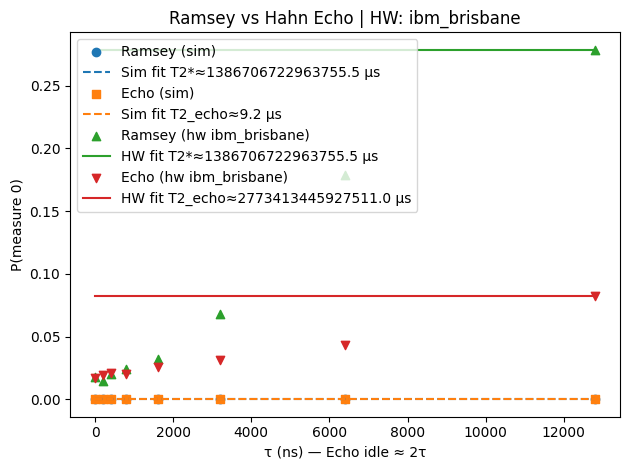

In [9]:
taus_sim   = sim["taus"]
ramsey_sim = sim["ramsey"]
echo_sim   = sim["echo"]

# --- fit simulation ---
A_r_s, C_r_s, T2s = fit_exp_decay(taus_sim, ramsey_sim, total_idle_factor=1.0)
A_e_s, C_e_s, T2e = fit_exp_decay(taus_sim, echo_sim,   total_idle_factor=2.0)

t_plot = np.linspace(0, float(taus_sim.max()), 300)
ramsey_fit_s = A_r_s * np.exp(-t_plot / T2s) + C_r_s
echo_fit_s   = A_e_s * np.exp(-(2 * t_plot) / T2e) + C_e_s

plt.figure()
title_bits = ["Ramsey vs Hahn Echo"]

# --- SIM curves ---
plt.scatter(taus_sim, ramsey_sim, label="Ramsey (sim)", marker="o")
plt.plot(t_plot, ramsey_fit_s, "--", label=f"Sim fit T2*≈{T2s/1000:.1f} μs")
plt.scatter(taus_sim, echo_sim, label="Echo (sim)", marker="s")
plt.plot(t_plot, echo_fit_s, "--", label=f"Sim fit T2_echo≈{T2e/1000:.1f} μs")

# --- HW (Sampler) if present ---
if "hw" in globals() and hw is not None:
    taus_hw   = hw["taus"]
    ramsey_hw = hw["ramsey"]
    echo_hw   = hw["echo"]

    A_r_h, C_r_h, T2s_h = fit_exp_decay(taus_hw, ramsey_hw, total_idle_factor=1.0)
    A_e_h, C_e_h, T2e_h = fit_exp_decay(taus_hw, echo_hw,   total_idle_factor=2.0)

    ramsey_fit_h = A_r_h * np.exp(-t_plot / T2s_h) + C_r_h
    echo_fit_h   = A_e_h * np.exp(-(2 * t_plot) / T2e_h) + C_e_h

    plt.scatter(taus_hw, ramsey_hw, label=f"Ramsey (hw {hw.get('backend','')})", marker="^")
    plt.plot(t_plot, ramsey_fit_h, "-", label=f"HW fit T2*≈{T2s_h/1000:.1f} μs")
    plt.scatter(taus_hw, echo_hw, label=f"Echo (hw {hw.get('backend','')})", marker="v")
    plt.plot(t_plot, echo_fit_h, "-", label=f"HW fit T2_echo≈{T2e_h/1000:.1f} μs")

    if "backend" in hw:
        title_bits.append(f"HW: {hw['backend']}")

# --- HW (Estimator with mitigation) if present ---
if "hw_est" in globals() and hw_est is not None:
    taus_hwe   = hw_est["taus"]
    ramsey_hwe = hw_est["ramsey"]
    echo_hwe   = hw_est["echo"]

    A_r_he, C_r_he, T2s_he = fit_exp_decay(taus_hwe, ramsey_hwe, total_idle_factor=1.0)
    A_e_he, C_e_he, T2e_he = fit_exp_decay(taus_hwe, echo_hwe,   total_idle_factor=2.0)

    ramsey_fit_he = A_r_he * np.exp(-t_plot / T2s_he) + C_r_he
    echo_fit_he   = A_e_he * np.exp(-(2 * t_plot) / T2e_he) + C_e_he

    plt.scatter(taus_hwe, ramsey_hwe, label=f"Ramsey (hw, Estimator+ZNE)", marker="D")
    plt.plot(t_plot, ramsey_fit_he, "-", label=f"HW+ZNE fit T2*≈{T2s_he/1000:.1f} μs")
    plt.scatter(taus_hwe, echo_hwe, label=f"Echo (hw, Estimator+ZNE)", marker="P")
    plt.plot(t_plot, echo_fit_he, "-", label=f"HW+ZNE fit T2_echo≈{T2e_he/1000:.1f} μs")

    if "backend" in hw_est:
        title_bits.append(f"HW(ZNE): {hw_est['backend']}")

plt.title(" | ".join(title_bits))
plt.xlabel("τ (ns) — Echo idle ≈ 2τ")
plt.ylabel("P(measure 0)")
plt.legend()
plt.tight_layout()
plt.show()

In [10]:
with open("echo_ramsey_results.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["tau_ns","ramsey_sim","echo_sim","ramsey_hw","echo_hw"])
    for i,tau in enumerate(sim["taus"]):
        writer.writerow([tau, sim["ramsey"][i], sim["echo"][i],
                         hw["ramsey"][i], hw["echo"][i]])

print("CSV saved: echo_ramsey_results.csv")

CSV saved: echo_ramsey_results.csv
